In [2]:
import os
import shutil
import random
from glob import glob

# Define the base path and the source directory for images
base_dir = r"d:\8_sem\Research Final Year\Models\Color_identiifcation"
source_dir = os.path.join(base_dir, "rename_img")

# Define destination directories
train_dir = os.path.join(base_dir, "data", "train")
val_dir = os.path.join(base_dir, "data", "val")
test_dir = os.path.join(base_dir, "data", "test")

# Create directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Get all image files (jpg and jpeg)
image_files = glob(os.path.join(source_dir, '*.jpg')) + glob(os.path.join(source_dir, '*.jpeg')) + glob(os.path.join(source_dir, '*.png'))
random.shuffle(image_files)

# Define split ratios
train_split = 0.8
val_split = 0.1
# test_split is the remainder

# Calculate split indices
total_files = len(image_files)
train_end = int(total_files * train_split)
val_end = train_end + int(total_files * val_split)

# Split the files
train_files = image_files[:train_end]
val_files = image_files[train_end:val_end]
test_files = image_files[val_end:]

# Function to move files
def move_files(files, destination_folder):
    for file_path in files:
        try:
            shutil.move(file_path, destination_folder)
        except Exception as e:
            print(f"Could not move {file_path}. Reason: {e}")

# Move the files to their new directories
print(f"Moving {len(train_files)} files to {train_dir}")
move_files(train_files, train_dir)

print(f"Moving {len(val_files)} files to {val_dir}")
move_files(val_files, val_dir)

print(f"Moving {len(test_files)} files to {test_dir}")
move_files(test_files, test_dir)

print("Data splitting complete.")

Moving 0 files to d:\8_sem\Research Final Year\Models\Color_identiifcation\data\train
Moving 0 files to d:\8_sem\Research Final Year\Models\Color_identiifcation\data\val
Moving 0 files to d:\8_sem\Research Final Year\Models\Color_identiifcation\data\test
Data splitting complete.


In [6]:
from PIL import Image
from torchvision import transforms,datasets
import os
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import time
import copy
from torch.optim import lr_scheduler

# --- Data transforms remain the same, they are already good ---
data_transforms = {
    "train" : transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "val":transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir ="data"
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=4)
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print(f"Class names: {class_names}")
print(f"Dataset sizes: {dataset_sizes}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. --- MODIFIED --- Load the model and unfreeze some layers for fine-tuning
model = models.efficientnet_v2_s(weights='IMAGENET1K_V1')

# Freeze all parameters first
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last block of features (optional, but often helps)
# For MobileNetV3-Large, layers from 13 onwards are the later blocks
for param in model.features[13:].parameters():
     param.requires_grad = True

# 2. --- MODIFIED --- Simplify the classifier and increase dropout
num_ftrs = model.classifier[-1].in_features
model.classifier[-1] = nn.Sequential(
    nn.Linear(num_ftrs, 256), # Reduced from 1280 to 512
    nn.Hardswish(),
    nn.Dropout(p=0.5, inplace=True), # Increased dropout from 0.4
    nn.Linear(256, len(class_names))
)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# 3. --- MODIFIED --- Set up optimizer for differential learning rates
# Give the newly unfrozen convolutional layers a lower learning rate
optimizer = optim.Adam([
    {'params': model.features[13:].parameters(), 'lr': 1e-5}, # Very low LR for fine-tuning
    {'params': model.classifier.parameters(), 'lr': 1e-3}     # Higher LR for the new classifier
], lr=1e-3, weight_decay=1e-4)


# 4. --- MODIFIED --- Use a more adaptive learning rate scheduler
# This will reduce the LR when validation loss stops improving
model_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)


# 5. --- MODIFIED --- Training function with Early Stopping
def train_model_efficient(model, criterion, optimizer, scheduler, num_epochs=50, patience=5): # Add patience parameter
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    # --- MODIFIED --- Add variables for early stopping
    epochs_no_improve = 0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # --- MODIFIED --- Early stopping logic and LR scheduler step
            if phase == 'val':
                # Step the scheduler on the validation loss
                scheduler.step(epoch_loss)

                if epoch_acc > best_acc:
                    print('Validation accuracy increased. Saving best model...')
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save(model.state_dict(), 'best_Efficientnet_model_v2.pth')
                    epochs_no_improve = 0 # Reset counter
                else:
                    epochs_no_improve += 1 # Increment counter
        
        print()
        
        # Check if training should be stopped
        if epochs_no_improve >= patience:
            print(f'Early stopping triggered after {patience} epochs with no improvement.')
            time_elapsed = time.time() - since
            print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
            print(f'Best val Acc: {best_acc:4f}')
            model.load_state_dict(best_model_wts)
            return model # Exit training loop

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model


Class names: ['blend', 'dark_shade', 'light_shade', 'white']
Dataset sizes: {'train': 247, 'val': 30}


In [ ]:
if __name__ == '__main__':
    model_ft_efficient = train_model_efficient(model, criterion, optimizer, model_lr_scheduler, num_epochs=50, patience=10)

Test Accuracy: 0.8438


Classification Report:
              precision    recall  f1-score   support

       blend       1.00      0.89      0.94         9
  dark_shade       0.50      0.80      0.62         5
 light_shade       0.88      0.70      0.78        10
       white       1.00      1.00      1.00         8

    accuracy                           0.84        32
   macro avg       0.84      0.85      0.83        32
weighted avg       0.88      0.84      0.85        32



Confusion Matrix:


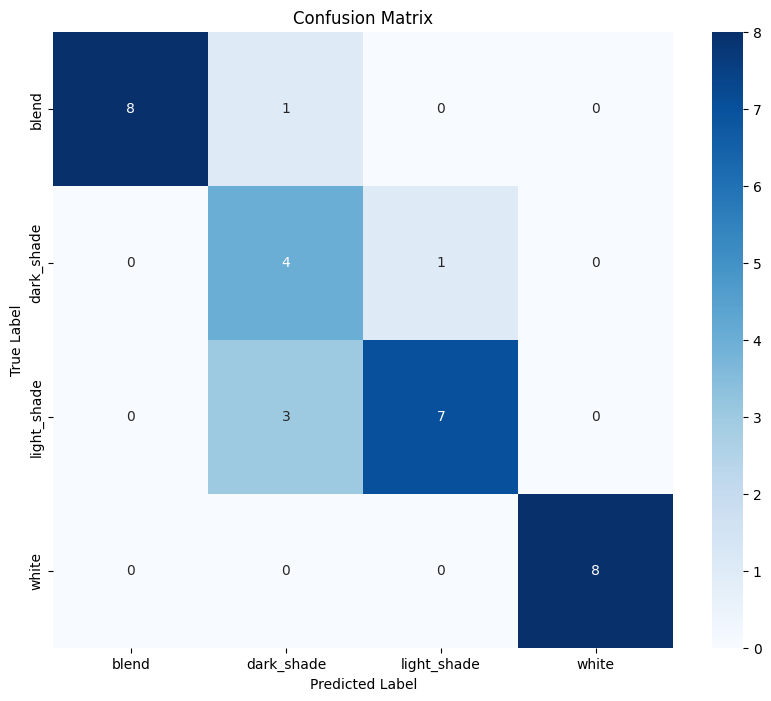

In [9]:
import torch
from torchvision import datasets, transforms
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Ensure the model is in evaluation mode
model_ft_efficient.eval()

# Define the transformation for the test set (should be same as validation)
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create the test dataset and dataloader
test_dir = os.path.join("data", "test")
test_dataset = datasets.ImageFolder(test_dir, test_transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Function to get all predictions from the test set
def get_all_preds(model, loader):
    all_preds = torch.tensor([]).to(device)
    all_labels = torch.tensor([]).to(device)
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds = torch.cat((all_preds, preds))
            all_labels = torch.cat((all_labels, labels))
    return all_preds.cpu().numpy(), all_labels.cpu().numpy()

# Get predictions and true labels
y_pred, y_true = get_all_preds(model_ft_efficient, test_dataloader)

# Get class names from the training dataset
class_names = image_datasets['train'].classes

# --- Calculate and Print Metrics ---

# 1. Accuracy Score
print(f"Test Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print("\n" + "="*30 + "\n")

# 2. Classification Report (Precision, Recall, F1-Score)
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))
print("\n" + "="*30 + "\n")

# 3. Confusion Matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()